In [6]:
from io import StringIO

import matplotlib.pyplot as plt
from scipy.io import arff
import seaborn as sns
from loguru import logger
import yaml

from datetime import datetime
import polars as pl
import pandas as pd
import numpy as np
import os

# MODEL
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import (
    LabelEncoder, 
    StandardScaler,
    label_binarize
)
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    accuracy_score,
    precision_recall_fscore_support,
    balanced_accuracy_score,
    roc_auc_score,
    roc_curve
)

# Save variables for model
import joblib


# PERSONAL FUNCTIONS
from utils import *
from functions.windows import create_feature_windows # creación de ventanas e ingenieria de características

**Nota:** Se determinó que el formato 'Timestamp' está en nanosegundos. Aunque se exploró con las otras métricas (microsegundos y milisegundos), ninguna coincidia con la frecuencia de muestreo de 20Hz se aproxima a 0.05 segundos.

In [2]:
# Cargar datos
path_base = r"F:\UPC\Tesis\HARbit-Model\src\data\wisdm-dataset\raw\watch"
sensor_data = load_sensors_separately(path_base)
df_gyro = sensor_data['gyro']
df_gyro = df_gyro.rename({'X': 'X_gyro', 'Y': 'Y_gyro', 'Z': 'Z_gyro'})

df_accel = sensor_data['accel']
df_accel = df_accel.rename({'X': 'X_accel', 'Y': 'Y_accel', 'Z': 'Z_accel'})

print(f"Giroscopio: {len(df_gyro)} muestras")
print(f"Acelerómetro: {len(df_accel)} muestras")

2025-09-13 09:00:45.342 | INFO     | utils.data_loading:load_sensors_separately:64 - Cargando datos de gyro...
2025-09-13 09:00:52.871 | INFO     | utils.data_loading:load_sensors_separately:64 - Cargando datos de accel...


Giroscopio: 3440341 muestras
Acelerómetro: 3777045 muestras


In [3]:
df_all_sensors = df_gyro.join(df_accel, on = ['Subject-id', 'Timestamp', 'Activity Label'], how = "inner")

In [4]:
df_gyro_inner = df_all_sensors.select(
    pl.col('Subject-id'),
    pl.col('Activity Label'),
    pl.col('Timestamp'),
    pl.col('X_gyro').alias('X'),
    pl.col('Y_gyro').alias('Y'),
    pl.col('Z_gyro').alias('Z')
)

In [5]:
df_accel_inner = df_all_sensors.select(
    pl.col('Subject-id'),
    pl.col('Activity Label'),
    pl.col('Timestamp'),
    pl.col('X_accel').alias('X'),
    pl.col('Y_accel').alias('Y'),
    pl.col('Z_accel').alias('Z')
)

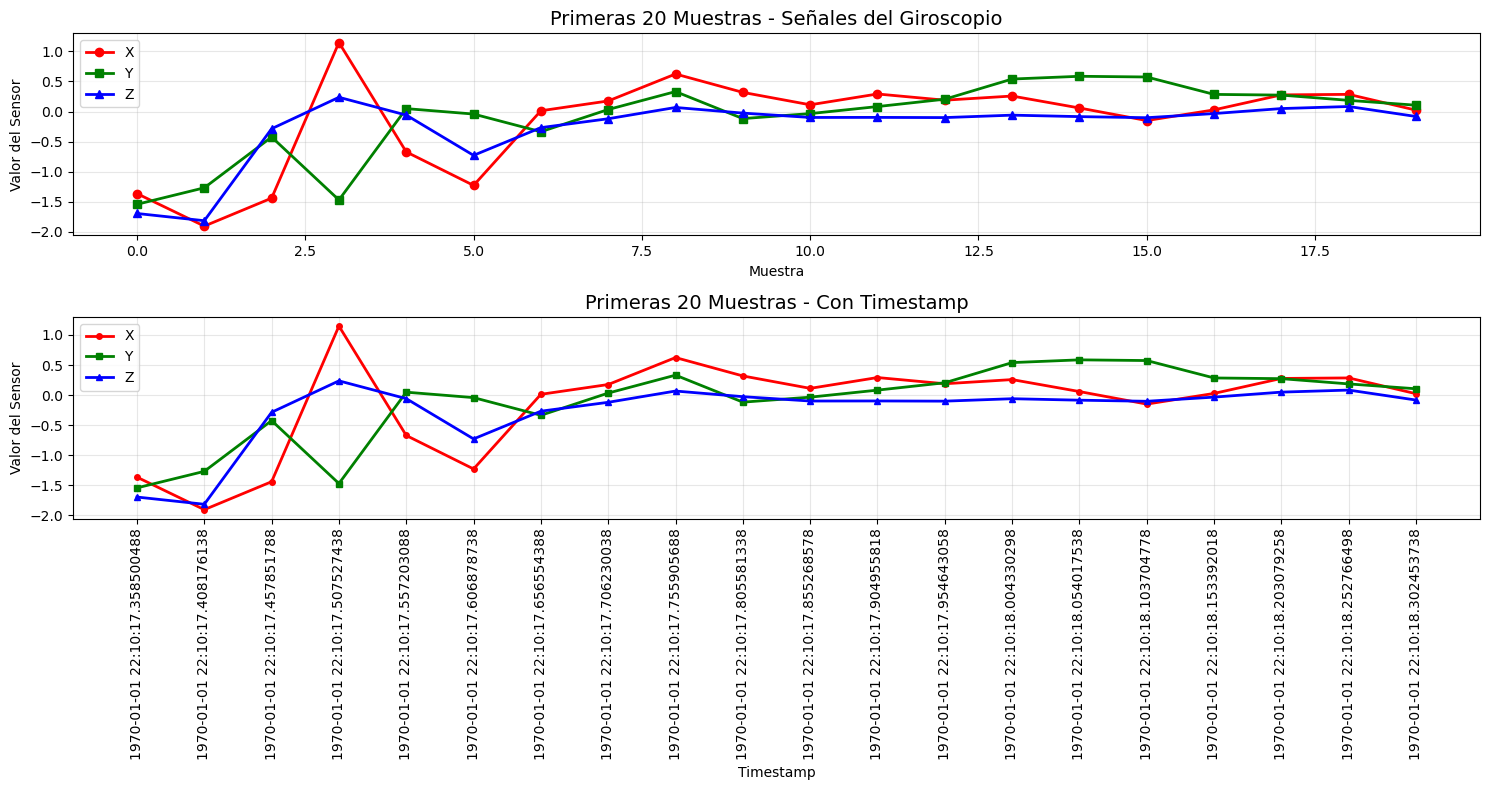

In [6]:
# Visualización de las primeras 20 muestras
plt.figure(figsize=(15, 8))

# Convertir a pandas para facilitar la visualización
df_sample = df.head(20).to_pandas()
df_sample['Tiempo Hora'] = df_sample['Timestamp'].dt.strftime('%H:%M:%S.%2f')

plt.subplot(2, 1, 1)
plt.plot(range(20), df_sample['X'], 'r-o', label='X', linewidth=2, markersize=6)
plt.plot(range(20), df_sample['Y'], 'g-s', label='Y', linewidth=2, markersize=6)
plt.plot(range(20), df_sample['Z'], 'b-^', label='Z', linewidth=2, markersize=6)
plt.title('Primeras 20 Muestras - Señales del Giroscopio', fontsize=14)
plt.xlabel('Muestra')
plt.ylabel('Valor del Sensor')
plt.legend()
plt.grid(True, alpha=0.3)

# Visualización con timestamp real
plt.subplot(2, 1, 2)
plt.plot(df_sample['Tiempo Hora'], df_sample['X'], 'r-o', label='X', linewidth=2, markersize=4)
plt.plot(df_sample['Tiempo Hora'], df_sample['Y'], 'g-s', label='Y', linewidth=2, markersize=4)
plt.plot(df_sample['Tiempo Hora'], df_sample['Z'], 'b-^', label='Z', linewidth=2, markersize=4)
plt.title('Primeras 20 Muestras - Con Timestamp', fontsize=14)
plt.xlabel('Timestamp')
plt.ylabel('Valor del Sensor')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

In [7]:
# Extraer características con diferentes sobrelapamientos
print("Extrayendo características...")

features_50_accel = create_feature_windows(df_accel_inner, window_seconds=5, overlap_percent=50)
features_50_gyro = create_feature_windows(df_gyro_inner, window_seconds=5, overlap_percent=50)

Extrayendo características...


In [ ]:
features_50_accel.to_csv(r'./data/preprocess/accel_50%-overlaping_5s-windows.csv', index = False)
features_50_gyro.to_csv(r'./data/preprocess/gyro_50%-overlaping_5s-windows.csv', index = False)

In [8]:
features_50_accel = pd.read_csv(r'./data/preprocess/accel_50%-overlaping_5s-windows.csv')
features_50_gyro = pd.read_csv(r'./data/preprocess/gyro_50%-overlaping_5s-windows.csv')

In [1]:
# # Visualización de características extraídas
# fig, axes = plt.subplots(2, 2, figsize=(20, 15))

# # Características de dominio del tiempo
# time_features = ['X_mean', 'Y_mean', 'Z_mean', 'X_std', 'Y_std', 'Z_std']
# features_50[time_features].plot(ax=axes[0,0], title='Características de Tiempo - Media y Desviación', linewidth=2)
# axes[0,0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# # Energía y RMS
# energy_features = ['X_energy', 'Y_energy', 'Z_energy', 'X_rms', 'Y_rms', 'Z_rms']
# features_50[energy_features].plot(ax=axes[0,1], title='Energía y RMS', linewidth=2)
# axes[0,1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# # Características espectrales
# spectral_features = ['X_spectral_energy', 'Y_spectral_energy', 'Z_spectral_energy']
# features_50[spectral_features].plot(ax=axes[1,0], title='Energía Espectral', linewidth=2)
# axes[1,0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# # Frecuencias dominantes
# freq_features = ['X_dominant_freq', 'Y_dominant_freq', 'Z_dominant_freq']
# features_50[freq_features].plot(ax=axes[1,1], title='Frecuencias Dominantes', linewidth=2)
# axes[1,1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# plt.tight_layout()
# plt.show()

In [9]:
features_combined = pd.merge(
    features_50_gyro,
    features_50_accel, 
    on=['Subject-id', 'Activity Label', 'window_start', 'window_end', 'sample_count'], 
    how="inner"
)

In [10]:
def prepare_features_for_cnn_lstm_direct(features_df):
    """
    Prepara características ya extraídas DIRECTAMENTE para CNN-LSTM
    Sin crear ventanas adicionales - cada fila es una muestra independiente
    """
    # Convertir a pandas si es necesario
    if hasattr(features_df, 'to_pandas'):
        features_df = features_df.to_pandas()

    # Identificar columnas de características
    metadata_cols = ['Subject-id', 'Activity Label', 'window_start', 'window_end', 'sample_count']
    feature_cols = [col for col in features_df.columns if col not in metadata_cols]
    
    print(f"Características detectadas: {len(feature_cols)}")
    print(f"Muestras totales: {len(features_df)}")
    
    # Extraer características y etiquetas directamente
    X = features_df[feature_cols].values
    y = features_df['Activity Label'].values
    subjects = features_df['Subject-id'].values
    
    # Reshape para CNN: (samples, timesteps=1, features)
    # Cada ventana de 5s es una muestra individual
    X_reshaped = X.reshape(X.shape[0], 1, X.shape[1])

    return X_reshaped, y, subjects #, feature_cols

# Preparar datos
print("Preparando datos para CNN-LSTM...")
X, y, subjects = prepare_features_for_cnn_lstm_direct(features_combined)

print(f"Forma de X: {X.shape}")
print(f"Forma de y: {y.shape}")
print(f"Actividades únicas: {np.unique(y)}")

# Codificar etiquetas
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_classes = len(label_encoder.classes_)

print(f"Número de clases: {num_classes}")
print(f"Clases: {label_encoder.classes_}")

# Normalizar datos
scaler = StandardScaler()
X_scaled = X.reshape(-1, X.shape[-1])
X_scaled = scaler.fit_transform(X_scaled)
X_scaled = X_scaled.reshape(X.shape)

# División train/validation/test
X_temp, X_test, y_temp, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

print(f"Train: {X_train.shape[0]} muestras")
print(f"Validation: {X_val.shape[0]} muestras")
print(f"Test: {X_test.shape[0]} muestras")

Preparando datos para CNN-LSTM...
Características detectadas: 136
Muestras totales: 60710
Forma de X: (60710, 1, 136)
Forma de y: (60710,)
Actividades únicas: ['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'O' 'P' 'Q' 'R' 'S']
Número de clases: 18
Clases: ['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'O' 'P' 'Q' 'R' 'S']
Train: 36426 muestras
Validation: 12142 muestras
Test: 12142 muestras


In [11]:
def create_cnn_lstm_model(input_shape, num_classes):
    # """
    # Crea modelo CNN-LSTM para clasificación de actividades
    # """
    # model = Sequential([
    #     # Capas Convolucionales para extracción de características locales
    #     Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
    #     BatchNormalization(),
    #     Conv1D(filters=64, kernel_size=3, activation='relu'),
    #     BatchNormalization(),
    #     MaxPooling1D(pool_size=2),
    #     Dropout(0.25),
        
    #     Conv1D(filters=128, kernel_size=3, activation='relu'),
    #     BatchNormalization(),
    #     Conv1D(filters=128, kernel_size=3, activation='relu'),
    #     BatchNormalization(),
    #     MaxPooling1D(pool_size=2),
    #     Dropout(0.25),
        
    #     # Capas LSTM para capturar dependencias temporales
    #     LSTM(100, return_sequences=True, dropout=0.3, recurrent_dropout=0.3),
    #     LSTM(50, dropout=0.3, recurrent_dropout=0.3),
        
    #     # Capas densas para clasificación
    #     Dense(100, activation='relu'),
    #     BatchNormalization(),
    #     Dropout(0.5),
    #     Dense(50, activation='relu'),
    #     Dropout(0.3),
    #     Dense(num_classes, activation='softmax')
    # ])

    """
    Modelo CNN-LSTM optimizado para características extraídas
    Diseñado para input_shape = (1, 68) - solo 1 timestep
    """
    model = Sequential([
        # Capa Conv1D con kernel_size=1 (no hay secuencia temporal)
        Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=input_shape),
        BatchNormalization(),
        Dropout(0.3),
        
        # Segunda capa Conv1D
        Conv1D(filters=128, kernel_size=1, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        
        # Tercera capa Conv1D para mayor extracción de características
        Conv1D(filters=256, kernel_size=1, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        
        # LSTM para procesar las características (aunque timestep=1, ayuda con representación)
        LSTM(128, return_sequences=False, dropout=0.4, recurrent_dropout=0.4),
        
        # Capas densas para clasificación final
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),
        
        Dense(64, activation='relu'),
        Dropout(0.3),
        
        Dense(num_classes, activation='softmax')
    ])
    
    
    return model

# Crear y compilar modelo
input_shape = (X_train.shape[1], X_train.shape[2])
model = create_cnn_lstm_model(input_shape, num_classes)

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Mostrar arquitectura del modelo
model.summary()

c:\Users\HP\miniconda3\envs\forecasting\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 1, 64)          │         8,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1, 128)         │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 1, 256)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1, 256)         │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 18)             │         1,170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 325,906 (1.24 MB)

 Trainable params: 324,242 (1.24 MB)

 Non-trainable params: 1,664 (6.50 KB)

In [12]:
# Callbacks para entrenamiento
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=8,
        min_lr=1e-7,
        verbose=1
    )
]

# Entrenar modelo
print("Entrenando modelo CNN-LSTM...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

Entrenando modelo CNN-LSTM...
Epoch 1/100
1139/1139 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.3238 - loss: 2.0394 - val_accuracy: 0.5752 - val_loss: 1.1513 - learning_rate: 0.0010
Epoch 2/100
1139/1139 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.5340 - loss: 1.3897 - val_accuracy: 0.6956 - val_loss: 0.9124 - learning_rate: 0.0010
Epoch 3/100
1139/1139 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.6175 - loss: 1.2103 - val_accuracy: 0.7258 - val_loss: 0.8568 - learning_rate: 0.0010
Epoch 4/100
1139/1139 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.6538 - loss: 1.1225 - val_accuracy: 0.7417 - val_loss: 0.8030 - learning_rate: 0.0010
Epoch 5/100
1139/1139 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.6736 - loss: 1.0631 - val_accuracy: 0.7501 - val_loss: 0.7896 - learning_rate: 0.0010
Epoch 6/100
1139/1139 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.6828 - loss: 1.0335 - val_accuracy: 0.7478 - val_loss: 0.7955 - learning_rate: 0.0010
Epoch 7/100
1139/1139 ━━━━━━

Evaluando modelo...
380/380 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step

Pérdida en test: 0.5636
Precisión en test: 0.8163

REPORTE DE CLASIFICACIÓN
              precision    recall  f1-score   support

           A     0.8609    0.8187    0.8393       673
           B     0.9834    0.9879    0.9856       659
           C     0.8171    0.7368    0.7749       661
           D     0.7160    0.7928    0.7524       690
           E     0.8398    0.8484    0.8441       686
           F     0.8953    0.9296    0.9121       653
           G     0.9607    0.9677    0.9642       682
           H     0.7579    0.7423    0.7500       679
           I     0.5281    0.6490    0.5823       681
           J     0.6772    0.7269    0.7011       681
           K     0.6809    0.6701    0.6755       688
           L     0.4660    0.1439    0.2199       667
           M     0.8464    0.9004    0.8726       673
           O     0.9210    0.9392    0.9300       658
           P     0.9816    0.9481    0.9646       6

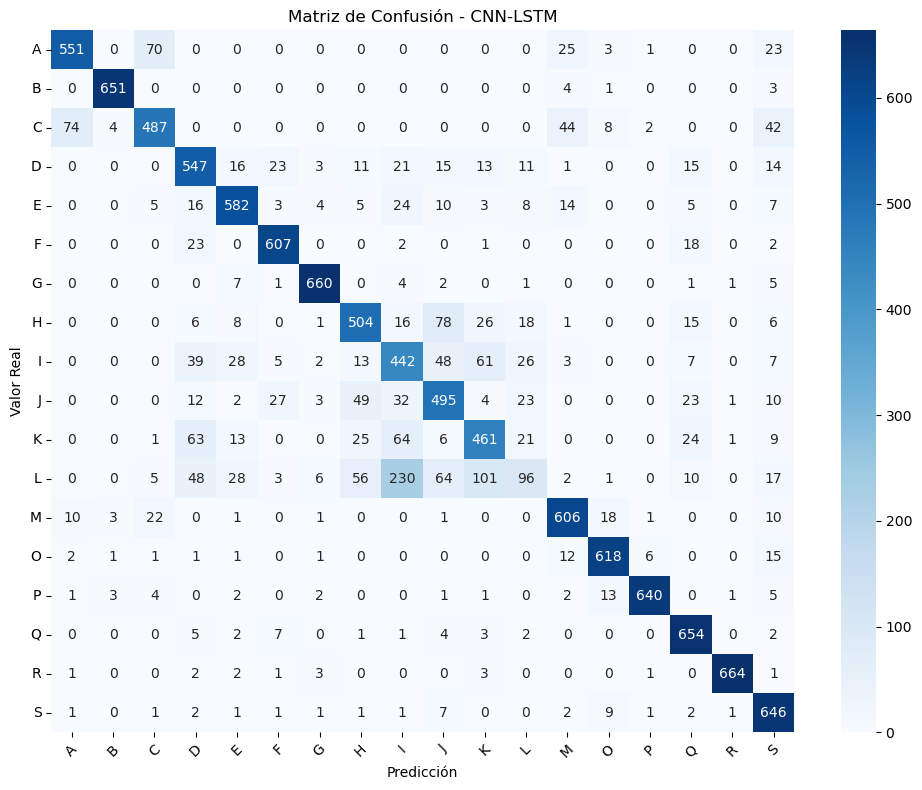

In [13]:
print("Evaluando modelo...")

# Predicciones
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Métricas básicas
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"\nPérdida en test: {test_loss:.4f}")
print(f"Precisión en test: {test_accuracy:.4f}")

# Reporte de clasificación detallado
print("\n" + "="*50)
print("REPORTE DE CLASIFICACIÓN")
print("="*50)
print(classification_report(
    y_test, 
    y_pred_classes, 
    target_names=label_encoder.classes_,
    digits=4
))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)
plt.title('Matriz de Confusión - CNN-LSTM')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [14]:
joblib.dump(label_encoder, r'./models/config/label_encoder.joblib')

['./models/config/label_encoder.joblib']


MÉTRICAS POR CLASE
   Actividad  Precisión  Recall  F1-Score  Soporte
0          A     0.8401  0.8276    0.8338      673
1          B     0.9775  0.9879    0.9826      659
2          C     0.8066  0.7383    0.7709      661
3          D     0.7486  0.7725    0.7603      690
4          E     0.8293  0.8499    0.8395      686
5          F     0.8830  0.9479    0.9143      653
6          G     0.9703  0.9575    0.9638      682
7          H     0.7123  0.7732    0.7415      679
8          I     0.5545  0.6270    0.5886      681
9          J     0.6962  0.6799    0.6880      681
10         K     0.6676  0.6715    0.6696      688
11         L     0.4317  0.2084    0.2811      667
12         M     0.8685  0.8930    0.8806      673
13         O     0.9365  0.9407    0.9386      658
14         P     0.9877  0.9481    0.9675      675
15         Q     0.8755  0.9604    0.9160      681
16         R     0.9866  0.9794    0.9830      678
17         S     0.7968  0.9557    0.8690      677

Precisión 

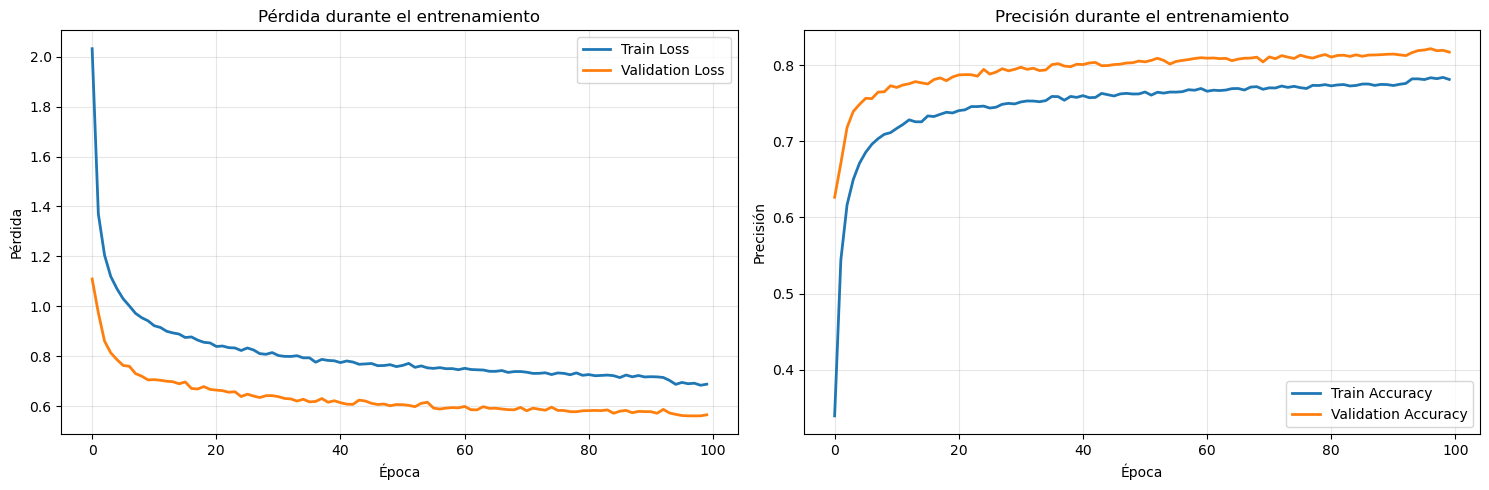


ANÁLISIS DE ERRORES POR ACTIVIDAD
   Actividad  Precisión  Errores  Total
0          A   0.827637      116    673
1          B   0.987860        8    659
2          C   0.738275      173    661
3          D   0.772464      157    690
4          E   0.849854      103    686
5          F   0.947933       34    653
6          G   0.957478       29    682
7          H   0.773196      154    679
8          I   0.627019      254    681
9          J   0.679883      218    681
10         K   0.671512      226    688
11         L   0.208396      528    667
12         M   0.893016       72    673
13         O   0.940729       39    658
14         P   0.948148       35    675
15         Q   0.960352       27    681
16         R   0.979351       14    678
17         S   0.955687       30    677


In [ ]:
# Métricas por clase
precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred_classes, average=None)

# Crear DataFrame con métricas por clase
metrics_df = pd.DataFrame({
    'Actividad': label_encoder.classes_,
    'Precisión': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Soporte': support
})

print("\n" + "="*60)
print("MÉTRICAS POR CLASE")
print("="*60)
print(metrics_df.round(4))

# Métricas globales adicionales
print(f"\nPrecisión promedio (macro): {precision.mean():.4f}")
print(f"Recall promedio (macro): {recall.mean():.4f}")
print(f"F1-Score promedio (macro): {f1.mean():.4f}")
print(f"Precisión balanceada: {balanced_accuracy_score(y_test, y_pred_classes):.4f}")

# Curvas de entrenamiento
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Pérdida
axes[0].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_title('Pérdida durante el entrenamiento')
axes[0].set_xlabel('Época')
axes[0].set_ylabel('Pérdida')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Precisión
axes[1].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[1].set_title('Precisión durante el entrenamiento')
axes[1].set_xlabel('Época')
axes[1].set_ylabel('Precisión')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Análisis de errores por actividad
error_analysis = []
for i, activity in enumerate(label_encoder.classes_):
    mask = y_test == i
    if mask.sum() > 0:
        activity_accuracy = accuracy_score(y_test[mask], y_pred_classes[mask])
        error_analysis.append({
            'Actividad': activity,
            'Precisión': activity_accuracy,
            'Errores': (y_test[mask] != y_pred_classes[mask]).sum(),
            'Total': mask.sum()
        })

error_df = pd.DataFrame(error_analysis)
print("\n" + "="*50)
print("ANÁLISIS DE ERRORES POR ACTIVIDAD")
print("="*50)
print(error_df)

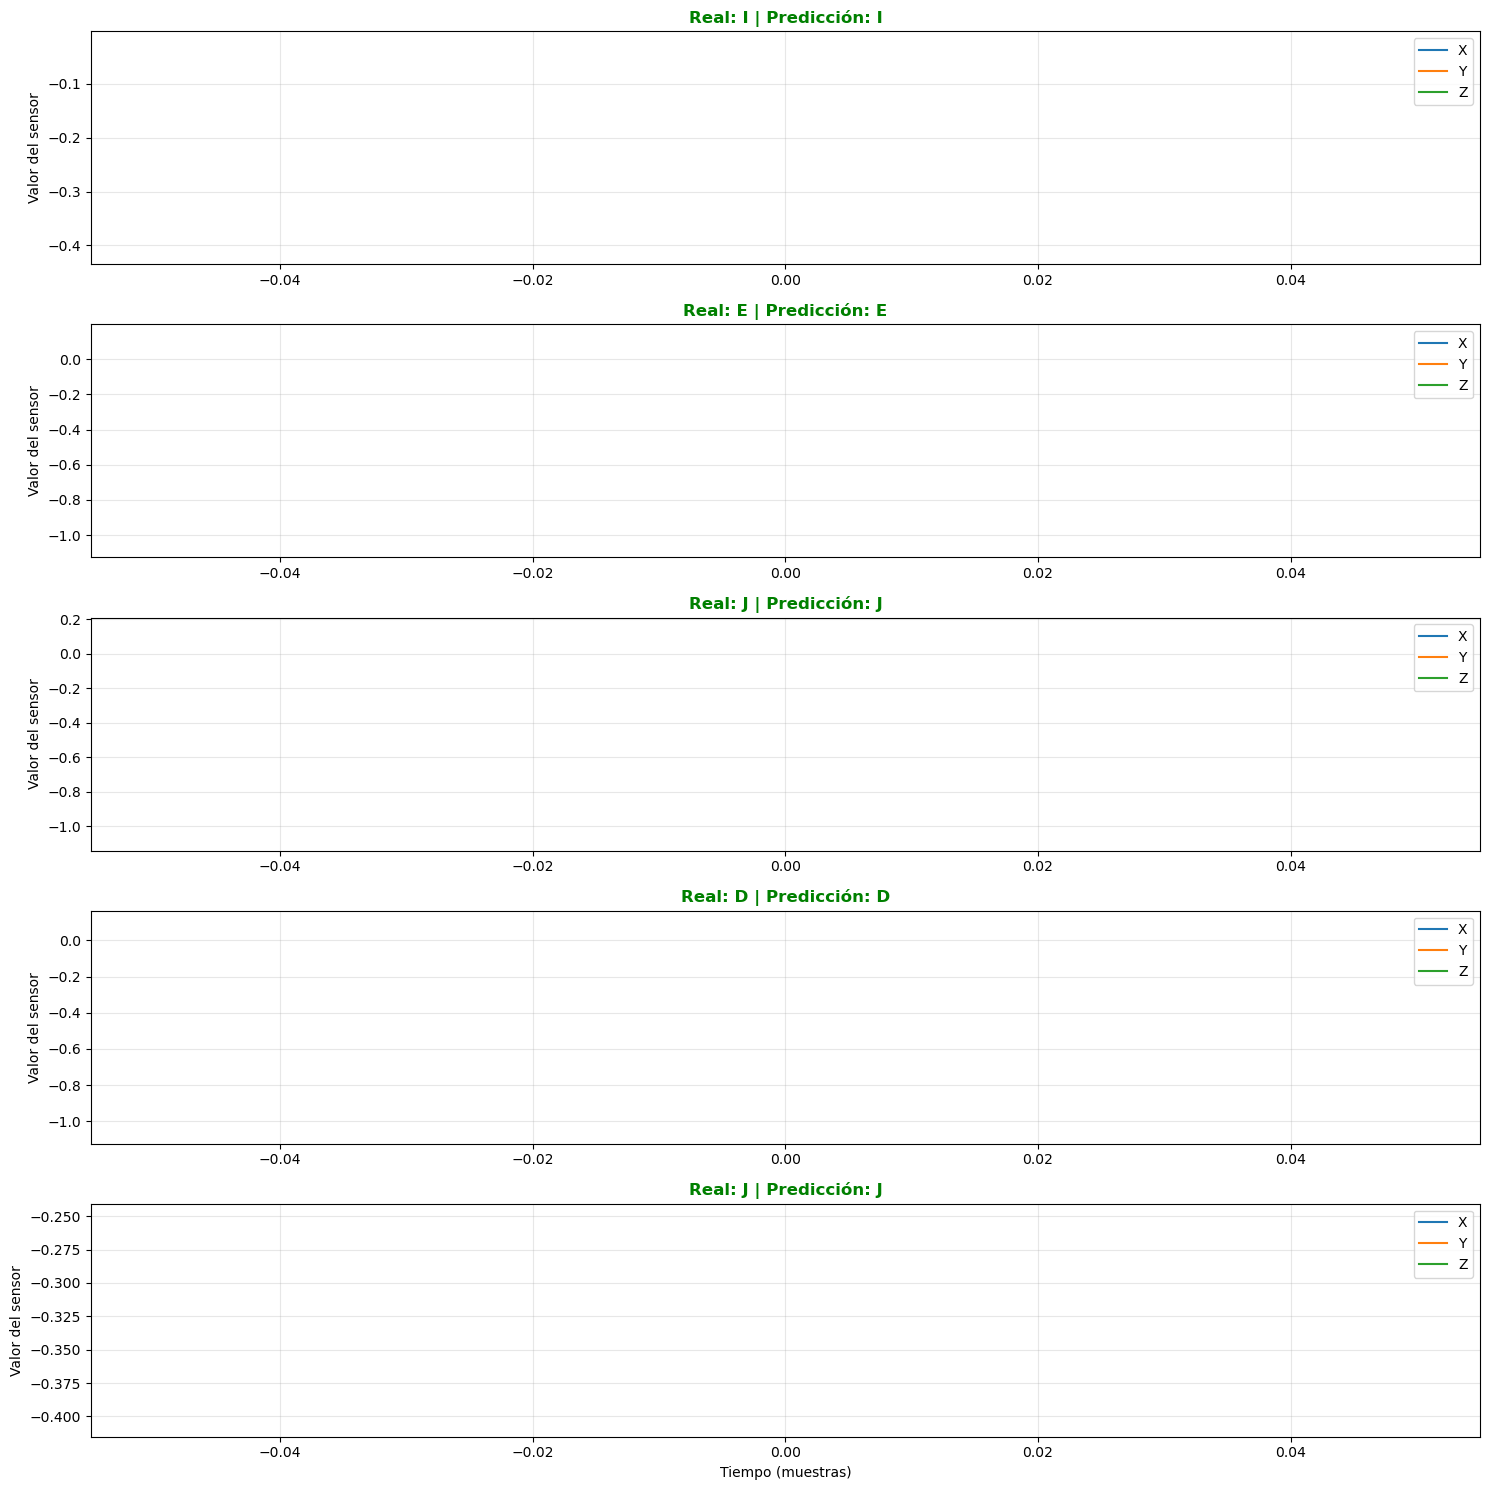


Resumen del modelo:
- Arquitectura: CNN-LSTM
- Ventana temporal: 1 muestras
- Características: 136 ejes (X, Y, Z)
- Clases: 18
- Precisión final: 0.8174
- Muestras de entrenamiento: 36426
- Muestras de test: 12142


In [21]:
def plot_prediction_examples(X_test, y_test, y_pred_classes, label_encoder, n_examples=5):
    """
    Muestra ejemplos de predicciones vs valores reales
    """
    fig, axes = plt.subplots(n_examples, 1, figsize=(15, 3*n_examples))
    
    # Seleccionar ejemplos aleatorios
    indices = np.random.choice(len(X_test), n_examples, replace=False)
    
    for i, idx in enumerate(indices):
        # Datos de la muestra
        sample = X_test[idx]
        true_label = label_encoder.classes_[y_test[idx]]
        pred_label = label_encoder.classes_[y_pred_classes[idx]]
        
        # Graficar las tres dimensiones
        axes[i].plot(sample[:, 0], label='X', linewidth=1.5)
        axes[i].plot(sample[:, 1], label='Y', linewidth=1.5)
        axes[i].plot(sample[:, 2], label='Z', linewidth=1.5)
        
        # Título con predicción
        color = 'green' if true_label == pred_label else 'red'
        axes[i].set_title(f'Real: {true_label} | Predicción: {pred_label}', 
                         color=color, fontweight='bold')
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)
        axes[i].set_ylabel('Valor del sensor')
        
        if i == n_examples - 1:
            axes[i].set_xlabel('Tiempo (muestras)')
    
    plt.tight_layout()
    plt.show()

# Mostrar ejemplos de predicciones
plot_prediction_examples(X_test, y_test, y_pred_classes, label_encoder, n_examples=5)

print(f"\nResumen del modelo:")
print(f"- Arquitectura: CNN-LSTM")
print(f"- Ventana temporal: {X_train.shape[1]} muestras")
print(f"- Características: {X_train.shape[2]} ejes (X, Y, Z)")
print(f"- Clases: {num_classes}")
print(f"- Precisión final: {test_accuracy:.4f}")
print(f"- Muestras de entrenamiento: {len(X_train)}")
print(f"- Muestras de test: {len(X_test)}")

Todos los modelos deben de guardarse con el siguiente formato:

**{nombre del modelo}_har_model_{precision}.h5**

Antes de ello, es importante revisar el rendimiento del modelo multiclase, así que no solo nos debemos de basar en la precision (accuracy), sino en el recall para tener en cuenta un posible desbalance entre clases en caso se presente el caso.

In [22]:
# Guardar modelo
model.save('./models/cnn-lstm_har_model_82.h5')
print("Modelo guardado como 'cnn-lstm_har_model_82.h5'")

Modelo guardado como 'cnn-lstm_har_model_82.h5'
